# Implementation of CoFi for marine traffic modeling

This notebook showcases how to use Consititional Filters (CoFi) in ProMis to improve modeling of ship movements.

## Setup

In [1]:
# This will auto-relead changed ProMis imports
%reload_ext autoreload
%autoreload 2

In [2]:
# We need some additional packages
!pip install -q svgpath2mpl svgpathtools filterpy keplergl

In [3]:
# Standard library
import json
from copy import copy
from math import ceil, isfinite
from pathlib import Path
from time import monotonic

# Math
import numpy as np
from numpy import array, deg2rad, eye, mean, ndarray, pi, set_printoptions, stack
from numpy.random import seed, standard_normal
from scipy.stats import norm, uniform

# Data Handling
import pandas as pd
from filterpy.monte_carlo import systematic_resample

# Plotting
import matplotlib
from keplergl import KeplerGl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.transforms import Affine2D
from seaborn import move_legend
from svgpath2mpl import parse_path
from svgpathtools import svg2paths
import seaborn as sns

# ProMis
from promis import ProMis, StaRMap
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianRasterBand,
    PolarCollection,
    PolarLocation,
)
from promis.loaders import NauticalChartLoader
from promis.logic.spatial import Depth


In [4]:
# Use full width of juptyer notebook
set_printoptions(linewidth=180, formatter={"float_kind": "{:4.6f}".format})

# Make plots look nice in a paper
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sns.set_theme(style="ticks", rc={"figure.figsize": (8, 3), "legend.title_fontsize": 15})
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

## Define the setting

In [5]:
# The format of the bbox is:
# (lat, lon) lower left, and then
# (lat, lon) upper right

setting = "New York Harbor"
bbox = (
    (40.52, -74.08),
    (40.70, -73.85),
)

# setting = "Port of Charleston, South Carolina"
# bbox = (
#     (32.75, -79.97),
#     (32.875, -79.87),
# )

# setting = "Baltimore"
# bbox = (
#     (39.174, -76.6304993),
#     (39.29, -76.4495423),
# )

# setting = "Port of Virginia (Norfolk)"
# bbox = (
#     (36.7711453, -76.4994133),
#     (37.3020172, -75.8786833),
# )

In [6]:
output_folder = Path(".") / "cofi-exports" / setting
output_folder.mkdir(exist_ok=True, parents=True)

In [7]:
origin = PolarLocation(
    latitude=mean([bbox[0][0], bbox[1][0]]), longitude=mean([bbox[0][1], bbox[1][1]])
)
width = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[0][0], longitude=bbox[1][1])
)
height = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[1][0], longitude=bbox[0][1])
)
dimensions = width, height
dimensions

(19490.788929051603, 19988.34793513066)

In [8]:
target_resolution = (200, 200)
support_resolution = (100, 100)

## Load the nautical chart data

Like all somewhat time-consuming steps, this only needs to be done once.

In [ ]:
uam_path = Path("nautical_chart_uam.pkl")

if uam_path.exists():
    uam = CartesianMap.load(uam_path)

else:
    loader = NauticalChartLoader(
        chart_root=Path(".").absolute().parent / "data" / "us_charts-ny",
        origin=origin,
        dimensions=dimensions,
    )
    loader.load(n_jobs=16)

    uam = loader.to_cartesian_map()
    uam.apply_covariance(50.0 * eye(2))

    uam.save(uam_path)

print(f"Loaded {len(uam.features)} features")

Warning 1: Illegal feature attribute id (ATTF:ATTL[0]) of 0
on feature FIDN=333478911, FIDS=7311.
Skipping attribute. No more warnings will be issued.


Loaded 3802 features


In [10]:
# Print the some features
for feature in uam.features[500:1000:31]:  # Get some diversity
    print(f"{type(feature).__name__} - {feature.location_type}: \t{feature.name}")

CartesianPolygon - anchorage: 	US5NYCCF#0226118FBFB01C82 (Anchor berth (single)): "G3"
CartesianPolygon - anchorage: 	US5NYCCF#022602C159BB1C82 (Anchor berth (single)): "O5"
CartesianPolygon - anchorage: 	US5NYCCF#022622152D461C82 (Anchor berth (single)): "K10"
CartesianPolygon - anchorage: 	US5NYCCF#022608F3C61E1C82 (Anchor berth (single)): "N6"
CartesianPolygon - anchorage: 	US5NYCCF#0226242A0CDD1C82 (Anchor berth (single)): "I6"
CartesianPolygon - anchorage: 	US5NYCCF#02260B6F82FB1C82 (Anchor berth (single)): "N8"
CartesianPolygon - anchorage: 	US5NYCCF#022639479B711C82 (Anchor berth (single)): "E5"
CartesianPolygon - anchorage: 	US5NYCCF#02263ABB47F41C82 (Anchor berth (single)): "M5"
CartesianPolygon - anchorage: 	US5NYCCF#02261DC124E61C82 (Anchor berth (single)): "F4"
CartesianPolygon - anchorage: 	US5NYCCF#02262DB2D5AE1C82 (Anchor berth (single)): "C9"
CartesianPolygon - anchorage: 	US5NYCCF#022605EDE0241C82 (Anchor berth (single)): "P2"
CartesianPolygon - anchorage: 	US5NYCCF#02

## Prepare the mission landscape

In [11]:
# logic = r"""
# % Background knowledge
# is_deep(X) :- A is depth(X, water), B is current_draft , A + B < -1, \+ over(X, land).

# 0.95::is_safe(X) :- is_deep(X), distance(X, land) > 50. %, \+ over(X, anchorage).

# bound_to_main_routes :- is_cargo ; is_cargo_hazardous ;
#     is_tanker ; is_tanker_hazardous ; length > 100.
# follows_main_routes(X) :- \+  bound_to_main_routes ; distance(X, waterway) < 400 ;
#     distance(X, waterway) > 2000.
# %is_sane_speed(X) :- \+ over(X, anchorage) ; speed_over_ground < 10.
# is_legal(X) :- follows_main_routes(X). %, is_sane_speed(X).

# is_useful(X) :- \+ is_search_and_rescue_vessels.
# 0.2::is_useful(X) :- is_search_and_rescue_vessels.
# 0.8::is_useful(X) :- is_search_and_rescue_vessels, distance(X, land) < 500.

# % This rule set does not model all possible bahavioral patterns of ships
# %0.1::is_ignorant.
# landscape(X) :- is_safe(X), is_legal(X), is_useful(X). % ; is_ignorant.
# """

logic = r"""
% Perception from sensors
draught ~ normal(3, 0.5).
0.01::anchoring.
0.1::travels_waterways.

% Background knowledge
sufficient_depth(X) :-
    A is depth(X, water), B is draught,
    A + B < -1.5, \+ over(X, land).

0.95::safe(X) :-
    sufficient_depth(X), distance(X, land) > 50.

proper_anchorage(X) :-
    anchoring, over(X, anchorage);
    \+ anchoring, \+ over(X, anchorage).

0.90::waterway_preference(X) :-
    travels_waterways, distance(X, waterway) < 400;
    \+ travels_waterways.

% Compliance with Constitution
landscape(X) :-
    proper_anchorage(X), safe(X),
    waterway_preference(X).
"""

support = CartesianRasterBand(origin, support_resolution, width, height)
target = CartesianRasterBand(origin, target_resolution, width, height)

In [12]:
# We create a statistical relational map (StaR Map) to represent the
# stochastic relationships in the environment, computing a raster of 100 x 100 points
# using linear interpolation of a sample set
before = monotonic()
star_map = StaRMap(target, uam, method="nearest")

star_map.initialize(
    # The sample points for which the relations will be computed directly
    support=support,
    # We now compute the Distance and Over relationships for the selected points
    # For this, we take many random samples from generated/possible map variations
    number_of_random_maps=5,  # TODO
    # The logic used later. This is required to determine which relationships to prepare
    logic=logic,
)
after = monotonic()

star_map.save("maritime_star_map.pkl")

runtime = after - before
f"Computed StaR Map in {runtime} seconds"

Output()

Output()

Output()

Output()

Output()

'Computed StaR Map in 79.41587011702359 seconds'

In [13]:
star_map = StaRMap.load("maritime_star_map.pkl")

### Visualize the relations

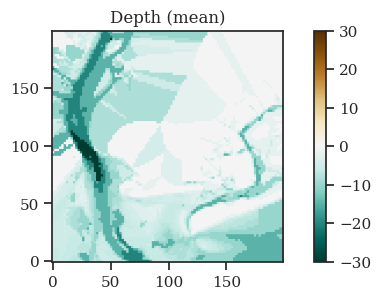

<Figure size 800x300 with 0 Axes>

In [14]:
# We first plot the depth since we have some special handling for it
depth: Depth = star_map.get("depth", "water")
plt.title("Depth (mean)")
depth.plot(value_index=0)
plt.show()
plt.clf()

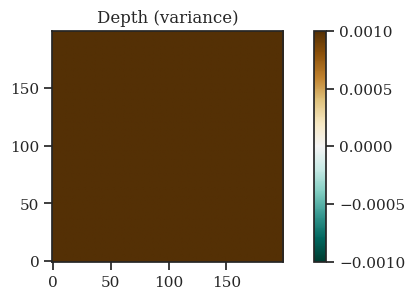

<Figure size 800x300 with 0 Axes>

In [15]:
plt.title("Depth (variance)")
depth.plot(value_index=1)
plt.show()
plt.clf()

In [16]:
all_relations = star_map.relation_and_location_types
all_relations

{'over': {'anchorage', 'land'},
 'distance': {'land', 'waterway'},
 'depth': {'water'}}

Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)


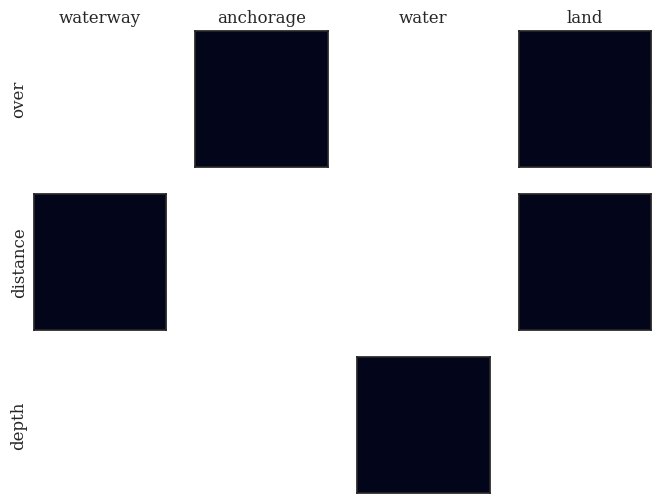

<Figure size 800x300 with 0 Axes>

In [ ]:
# Create one row per relation type and one column per location type
fig, axes = plt.subplots(
    len(all_relations), len(star_map.location_types), figsize=(8, 6), sharex=True, sharey=True
)

for i, (relation_type, location_types) in enumerate(all_relations.items()):
    for j, location_type in enumerate(star_map.location_types):
        # Get the axis for the current row and column
        ax = axes[i, j]

        # Label the rows and columns
        if j == 0:
            ax.set_ylabel(relation_type)
        if i == 0:
            ax.set_title(location_type)

        # Get the relation and visualize it
        if location_type in location_types:
            relation = star_map.get(relation_type, location_type)
            relation.parameters.scatter(ax=ax, alpha=0.5, value_index=0)
        else:
            # No data available, but we still want to show the label
            ax.set_xticks([])
            ax.set_yticks([])
            # Despine
            sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)

        # if j == len(all_location_types) - 1:
        #     plt.colorbar()

plt.show()
plt.clf()

Lowered zoom level to keep map size reasonable. (z = 12)


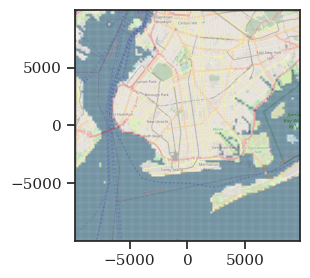

<Figure size 800x300 with 0 Axes>

In [18]:
relation = star_map.get("over", "land")
relation.parameters.scatter(vmin=0, s=0.1, alpha=0.2)
plt.show()
plt.clf()

In [19]:
folder = output_folder / "relations"
folder.mkdir(exist_ok=True)

for relation_type, location_types in star_map.relation_and_location_types.items():
    for location_type in location_types:
        relation = star_map.get(relation_type, location_type)
        path = folder / f"{relation_type}_{location_type}.csv"
        relation.parameters.to_polar().to_csv(path)

### Run some inference

To make sure everything will run smoothly, we can run some inference on the data.

In [20]:
# In ProMis, we define the constraints of the mission
# as hybrid probabilistic first-order logic programs

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map)


% Perception from sensors
draught ~ normal(3, 0.5).
0.01::anchoring.
0.1::travels_waterways.

% Background knowledge
sufficient_depth(X) :-
    A is depth(X, water), B is draught,
    A + B < -1.5, \+ over(X, land).

0.95::safe(X) :-
    sufficient_depth(X), distance(X, land) > 50.

proper_anchorage(X) :-
    anchoring, over(X, anchorage);
    \+ anchoring, \+ over(X, anchorage).

0.90::waterway_preference(X) :-
    travels_waterways, distance(X, waterway) < 400;
    \+ travels_waterways.

% Compliance with Constitution
landscape(X) :-
    proper_anchorage(X), safe(X),
    waterway_preference(X).

distance(x_0, waterway) ~ normal(3062.361577277537, 0.001).
distance(x_0, land) ~ normal(3731.38903012275, 0.001).
depth(x_0, water) ~ normal(-6.0, 0.001).
0.0::over(x_0, anchorage).
0.0::over(x_0, land).
query(landscape(x_0)).
distance(x_1, waterway) ~ normal(2865.4850686239174, 0.001).
distance(x_1, land) ~ normal(3566.6827659221826, 0.001).
depth(x_1, water) ~ normal(-6.0, 0.001).
0.0::ov

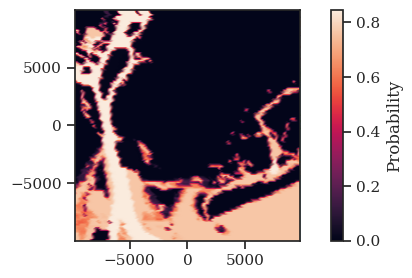

<Figure size 800x300 with 0 Axes>

In [21]:
# Solve an example logic program
landscape = promis.solve(support, logic, n_jobs=16, batch_size=3, print_first=True)

# Show the resulting landscape
ax = landscape.scatter()
plt.colorbar(ax, label="Probability")
plt.show()
plt.clf()

## Load some AIS data

The Automatic Identification System (AIS) is a system used for tracking ships. We will use its observations as our measurements and for model validation.

In [22]:
vessel_types = json.loads((Path("..") / "data" / "vessel_types_simplified.json").read_text())
# vessel_types

In [23]:
def load_ais(
    path: str | Path, bbox: None | tuple[tuple[float, float], tuple[float, float]]
) -> pd.DataFrame:
    # Read the csv into pandas
    df = pd.read_csv(path)

    # Filter by bounding box
    if bbox is not None:
        # This is a overly simplistic bounding box filter that only works on moderate latitudes
        # and far from the dateline
        df = df[
            (df["LAT"] > bbox[0][0])
            & (df["LAT"] < bbox[1][0])
            & (df["LON"] > bbox[0][1])
            & (df["LON"] < bbox[1][1])
        ]

    # Sort by time per ship
    df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])
    df.sort_values(["MMSI", "BaseDateTime"], inplace=True)

    df.loc[df["VesselType"].isna(), "VesselType"] = 0  # Zero means unknown

    df["VesselType"] = df["VesselType"].astype(int)
    df["VesselTypeName"] = df["VesselType"].astype(str).map(vessel_types)

    # Filter out all vessels that have an average SOG of less than 1 knot
    df = df.groupby("MMSI").filter(lambda x: x["SOG"].mean() > 1)

    return df


df = load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_01.csv", bbox=bbox)
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName
9007215,232040168,2023-08-01 19:06:21,40.52027,-74.03197,8.7,339.7,344.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6671099,232040168,2023-08-01 19:07:49,40.52332,-74.03350,7.9,336.6,345.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
9009252,232040168,2023-08-01 19:09:19,40.52637,-74.03515,7.9,340.2,349.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6685546,232040168,2023-08-01 19:10:21,40.52848,-74.03587,8.7,353.3,356.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6697396,232040168,2023-08-01 19:12:25,40.53272,-74.03660,5.5,344.6,357.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899297,636092711,2023-08-01 05:35:27,40.53780,-74.02317,17.3,156.9,155.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
1892555,636092711,2023-08-01 05:36:33,40.53303,-74.02010,17.2,151.1,144.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
1906669,636092711,2023-08-01 05:37:39,40.52898,-74.01588,16.9,138.2,132.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
1895628,636092711,2023-08-01 05:38:45,40.52550,-74.01085,17.0,129.9,124.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo


In [24]:
df["Draft"].value_counts(dropna=False)

Draft
NaN     19500
0.0      6352
4.1      2055
4.2      1875
3.9      1455
4.0       893
2.0       853
4.6       772
1.9       755
3.6       714
3.4       666
2.8       622
3.8       615
3.0       450
14.8      435
3.5       423
1.5       404
3.2       337
5.9       274
4.9       268
2.9       244
1.4       201
4.3       197
6.3       190
3.1       181
1.2       165
4.4       161
2.1       155
3.3       147
3.7       131
11.5      121
5.0       118
2.5       104
1.0        98
9.7        90
10.8       60
13.9       56
13.7       51
11.3       49
6.0        48
8.5        42
9.9        40
1.6        39
7.9        39
7.8        37
9.0        35
8.6        32
2.3        29
6.6        25
11.0       18
4.8         9
13.6        6
12.7        3
Name: count, dtype: int64

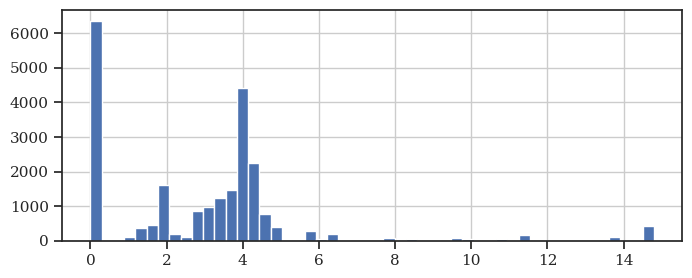

In [25]:
df["Draft"].hist(bins=50)
pass

In [26]:
df["Status"].value_counts().sort_index()

Status
0.0     31495
1.0       924
5.0      3583
6.0       206
7.0        82
8.0       169
11.0       45
12.0     2678
15.0     1943
Name: count, dtype: int64

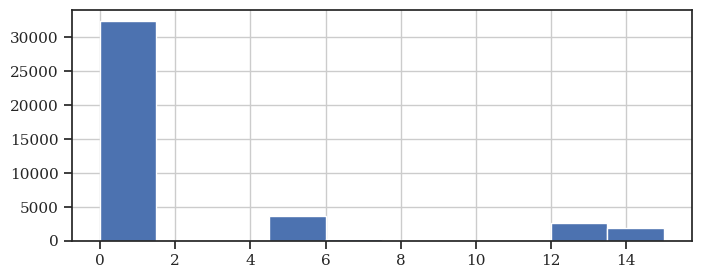

In [27]:
df["Status"].hist()
pass

In [28]:
collection = PolarCollection(origin=origin, number_of_values=0)
collection.append_with_default(df[["LON", "LAT"]].values, value=())
cartesian = collection.to_cartesian()

df.loc[:, "East"] = cartesian.data["east"].values
df.loc[:, "North"] = cartesian.data["north"].values
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,East,North
9007215,232040168,2023-08-01 19:06:21,40.52027,-74.03197,8.7,339.7,344.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5675.188325,-9961.958870
6671099,232040168,2023-08-01 19:07:49,40.52332,-74.03350,7.9,336.6,345.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5804.580884,-9623.172981
9009252,232040168,2023-08-01 19:09:19,40.52637,-74.03515,7.9,340.2,349.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5944.129822,-9284.376577
6685546,232040168,2023-08-01 19:10:21,40.52848,-74.03587,8.7,353.3,356.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-6004.950390,-9050.023266
6697396,232040168,2023-08-01 19:12:25,40.53272,-74.03660,5.5,344.6,357.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-6066.422330,-8579.143087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899297,636092711,2023-08-01 05:35:27,40.53780,-74.02317,17.3,156.9,155.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,-4928.172225,-8015.872204
1892555,636092711,2023-08-01 05:36:33,40.53303,-74.02010,17.2,151.1,144.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,-4668.412352,-8545.723697
1906669,636092711,2023-08-01 05:37:39,40.52898,-74.01588,16.9,138.2,132.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,-4311.127405,-8995.670285
1895628,636092711,2023-08-01 05:38:45,40.52550,-74.01085,17.0,129.9,124.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,-3885.130010,-9382.339931


### Visualize it

In [29]:
MMSIs = df["MMSI"].value_counts()
min_observations = 10 + 20 + 15  # warmup + some usage in between + dead_reckoning
relevant_MMSIs = MMSIs[MMSIs > min_observations].index
df = df[df["MMSI"].isin(relevant_MMSIs)]

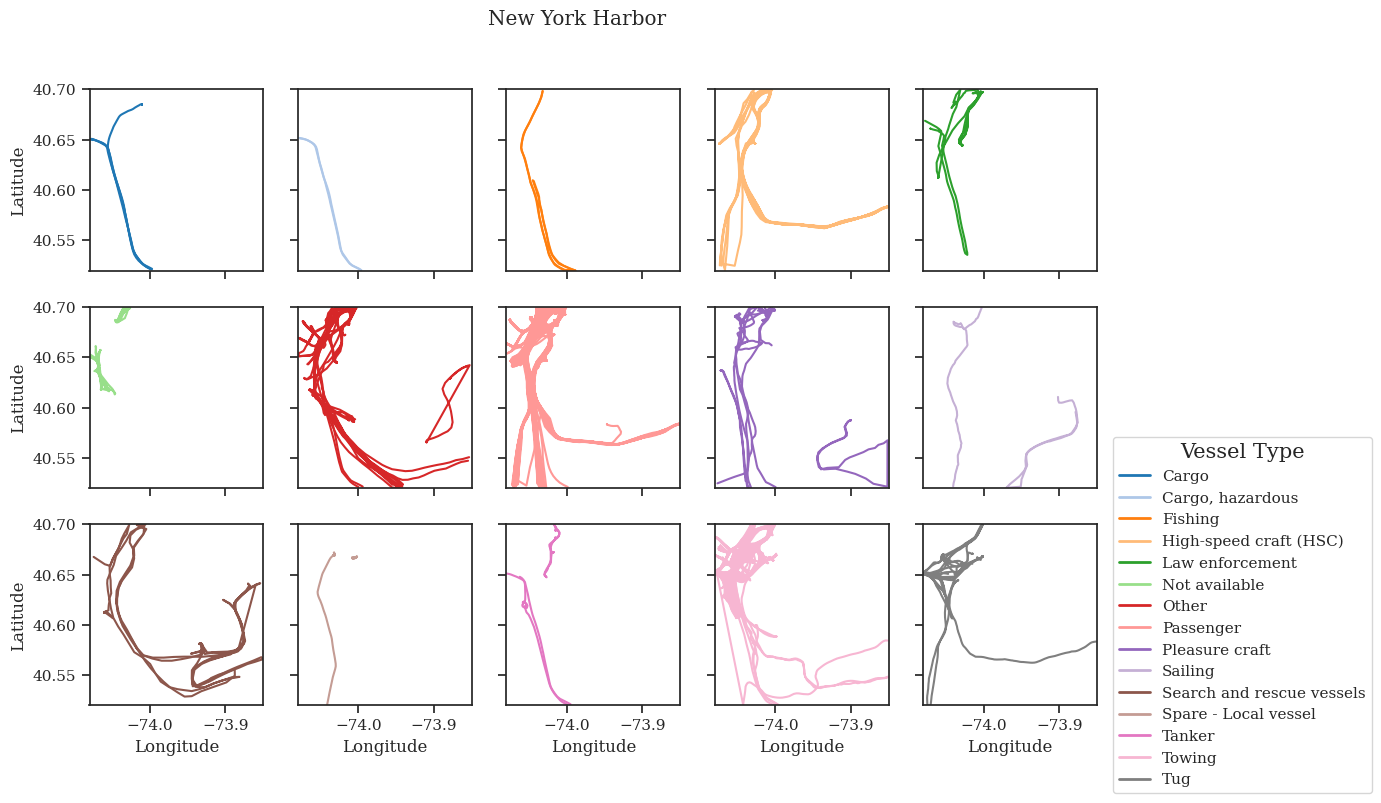

<Figure size 800x300 with 0 Axes>

In [30]:
vessel_type_to_index = {
    vessel_type: i for i, vessel_type in enumerate(sorted(df["VesselTypeName"].unique()))
}
palette = sns.color_palette("tab20", len(vessel_type_to_index))

relevant_vessel_types = df["VesselTypeName"].unique()

cols = 5
all_rows = ceil(len(relevant_vessel_types) / cols)
fig, ax = plt.subplots(ncols=cols, nrows=all_rows, figsize=(13, 8), sharex=True, sharey=True)

for (vessel_type, i), ax in zip(vessel_type_to_index.items(), ax.flatten()):
    for mmsi in relevant_MMSIs:
        df_ = df[df["MMSI"] == mmsi]
        if relevant_vessel_types is not None and df_["VesselTypeName"].iloc[0] != vessel_type:
            continue
        vessel_type = df_["VesselTypeName"].iloc[0]
        color = palette[vessel_type_to_index[vessel_type]]
        ax.plot(df_["LON"], df_["LAT"], c=color)

    ax.set_xlim(bbox[0][1], bbox[1][1])
    if i >= cols * (all_rows - 1):
        ax.set_xlabel("Longitude")
    ax.set_ylim(bbox[0][0], bbox[1][0])
    if i % cols == 0:
        ax.set_ylabel("Latitude")

    col = i % cols
    row = i // cols
    # if we are in the center, right-hand side
    if col == cols - 1 and row == len(relevant_vessel_types) // cols - 1:
        ax.legend(
            [
                plt.Line2D([0], [0], color=palette[i], lw=2, label=vessel_type)
                for i, vessel_type in enumerate(vessel_type_to_index)
            ],
            vessel_type_to_index.keys(),
            title="Vessel Type",
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
        )

plt.suptitle(setting)

plt.savefig(output_folder / "ais-all-tracks.pdf", bbox_inches="tight")

plt.show()
plt.clf()

In [31]:
relevant_vessel_types = [
    "Cargo",
    "Cargo hazardous",
    "Search and rescue vessels",
    "Towing",
    "Other",
    "Tanker",
    "Tanker hazardous",
]

In [32]:
for mmsi in relevant_MMSIs:
    df_ = df[df["MMSI"] == mmsi]
    if df_["VesselTypeName"].iloc[0] not in relevant_vessel_types:
        continue

    plt.plot(df_["LON"], df_["LAT"], c=color)
    plt.xlim(bbox[0][1], bbox[1][1])
    plt.ylim(bbox[0][0], bbox[1][0])
    plt.gca().set_aspect("equal")

    path = output_folder / "plot-individual-traces" / df_["VesselTypeName"].iloc[0]
    path.mkdir(exist_ok=True, parents=True)
    plt.savefig(path / f"{mmsi}.pdf", bbox_inches="tight")
    plt.clf()

<Figure size 800x300 with 0 Axes>

In [33]:
# An example of a single vessel
track_mmsi = 636017103
track_mmsi

636017103

In [34]:
df_ = df[df["MMSI"] == track_mmsi]
df_

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,East,North
8684223,636017103,2023-08-01 12:42:33,40.52173,-73.99979,14.1,297.4,297.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-2948.118757,-9801.407044
4277332,636017103,2023-08-01 12:43:39,40.52370,-74.00477,14.0,297.5,299.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-3370.027333,-9582.470582
4289181,636017103,2023-08-01 12:44:45,40.52617,-74.00927,13.7,313.2,317.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-3751.210309,-9308.008359
4296179,636017103,2023-08-01 12:45:52,40.52931,-74.01278,13.5,322.8,323.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-4048.440577,-8959.172452
4301282,636017103,2023-08-01 12:46:58,40.53263,-74.01607,13.6,323.1,323.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-4326.991573,-8590.347249
4307443,636017103,2023-08-01 12:47:59,40.53573,-74.01908,13.7,324.8,326.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-4581.807728,-8245.955907
4319559,636017103,2023-08-01 12:49:09,40.53969,-74.02179,13.6,339.8,342.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-4811.123179,-7806.073364
4327723,636017103,2023-08-01 12:50:19,40.54401,-74.02339,13.7,346.0,347.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-4946.353875,-7326.270097
4376598,636017103,2023-08-01 12:51:29,40.54825,-74.02470,13.3,346.7,347.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-5057.008143,-6855.364301
4337261,636017103,2023-08-01 12:52:39,40.55244,-74.02601,13.0,347.2,347.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-5167.652230,-6390.008770


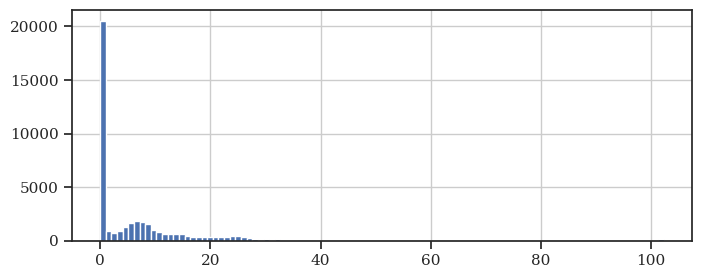

In [35]:
df["SOG"].hist(bins=100)
pass

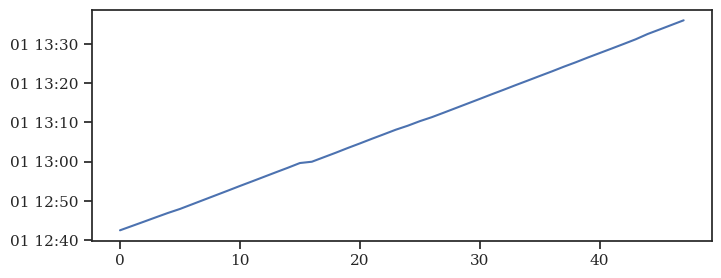

In [36]:
plt.plot(np.arange(len(df_["BaseDateTime"])), df_["BaseDateTime"])
pass

## Compute the ProMis landscapes for the ship categories

In [37]:
def landscape_for_mmsi(mmsi: int) -> CartesianCollection:
    metadata = df[df["MMSI"] == mmsi].iloc[0]

    specific = copy(logic)

    vessel_type = metadata["VesselTypeName"].replace(" ", "_").lower()
    specific += f"\nis_{vessel_type}."
    for vessel_type in relevant_vessel_types:
        if vessel_type != metadata["VesselTypeName"]:
            specific += f"\n0::is_{vessel_type.replace(' ', '_').lower()}."

    length = metadata["Length"]
    if isfinite(length) and length > 0:
        specific += f"\nlength ~ normal({length}, {length * 0.05})."
    else:
        # Some prior knowledge
        specific += "\nlength ~ normal(30, 10)."

    draft = metadata["Draft"]
    if isfinite(length) and draft > 0:
        specific += f"\ncurrent_draft ~ normal({draft}, {draft * 0.1})."
    else:
        # Some prior knowledge
        specific += "\ncurrent_draft ~ normal(2, 1)."

    # This is an example of a time varying feature
    # speed_over_ground = metadata["SOG"]
    # if isfinite(speed_over_ground):
    #     specific += f"\nspeed_over_ground ~ normal({speed_over_ground}, {speed_over_ground*0.1})."
    # else:
    #     # Some prior knowledge
    #     specific += "\nspeed_over_ground ~ normal(5, 5)."

    specific += "\n\n"  # Add newlines for better readability

    return promis.solve(support, specific, n_jobs=16, show_progress=False)


landscapes = {
    "Cargo": landscape_for_mmsi(636017103),
    "Search and rescue vessels": landscape_for_mmsi(367531710),
    "Towing": landscape_for_mmsi(303461000),
}

### Save them for external use

In [38]:
for vessel_type, landscape in landscapes.items():
    # Store the landscape
    path = output_folder / "landscape"
    path.mkdir(exist_ok=True)
    landscape.to_polar().to_csv(path / f"{vessel_type}.csv")

    # Store the trace of the vessels
    df_ = df[df["VesselTypeName"] == vessel_type]
    path = output_folder / "ais-trace"
    path.mkdir(exist_ok=True)
    df_[["MMSI", "LAT", "LON"]].to_csv(path / f"{vessel_type}.csv", index=False)

### Visualize the landscapes

In [39]:
# This will be used much later
ship_marker = parse_path(svg2paths("ship-icon.svg")[1][0]["d"])
ship_marker.vertices -= ship_marker.vertices.mean(axis=0)
ship_marker = ship_marker.transformed(Affine2D().rotate_deg(180)).transformed(
    Affine2D().scale(-1, 1)
)

Lowered zoom level to keep map size reasonable. (z = 12)


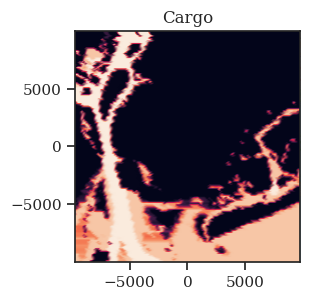

Lowered zoom level to keep map size reasonable. (z = 12)


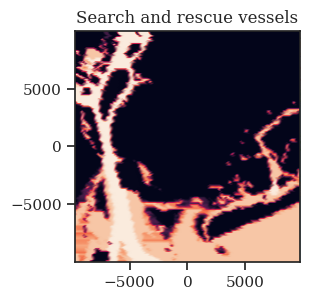

Lowered zoom level to keep map size reasonable. (z = 12)


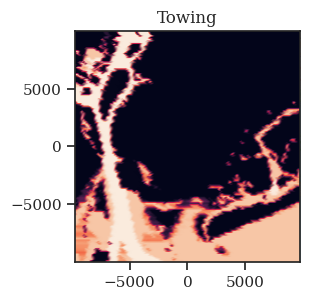

<Figure size 800x300 with 0 Axes>

In [40]:
for name, landscape in landscapes.items():
    landscape.scatter()
    plt.title(name)
    plt.show()
    plt.clf()

In [41]:
interpolators = {
    vessel_type: landscape.get_interpolator(method="nearest")
    for vessel_type, landscape in landscapes.items()
}

In [42]:
typical_ship_speed = 5  # meters per second
typical_sample_time = 60  # seconds

In [43]:
def plot_trajectories(all_positions: ndarray, label: str | None = "Trajectory {}", **kwargs):
    if len(all_positions.shape) == 2:
        all_positions = all_positions[None, ...]
    for i, positions in enumerate(all_positions):
        plt.plot(*zip(*positions), label=label.format(i) if label else None, **kwargs)

Lowered zoom level to keep map size reasonable. (z = 12)


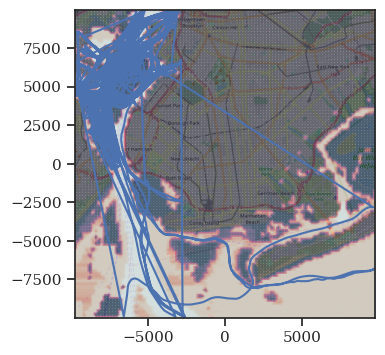

<Figure size 800x300 with 0 Axes>

In [44]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.2, alpha=0.5)
positions = stack((df_["East"], df_["North"])).T
plot_trajectories(positions, label="True trajectory")
plt.show()
plt.clf()
pass

In [45]:
def plot_trajectories_animated(positions: ndarray, filename: str = "trajectory.gif") -> None:
    fig, _ = plt.subplots()
    landscape.scatter()
    (line,) = plt.plot(*zip(*positions.T), label="Ship Position")

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        line.axes.axis([-width / 2, width / 2, -height / 2, height / 2])
        return (line,)

    ani = FuncAnimation(
        fig,
        update,
        len(positions),
        fargs=[positions[:, 0], positions[:, 1], line],
        interval=1000 / 60,
        blit=True,
    )
    ani.save(filename)
    plt.clf()


# plot_trajectories_animated(positions)

## Implement CoFi using a particle filter

We directly define the experiments that we will run.

In [46]:
def run_experiment_pf1(
    data: ndarray,
    seed_value: int = 2024,
    constitutional_trust: float = 0.8,
    interpolator=None,
    full_inference: bool = False,
    use_constitution: bool = True,
) -> pd.DataFrame:
    def create_initial_particles(N: int) -> ndarray:
        return np.stack(
            [
                uniform(loc=-width / 2, scale=width).rvs(N),
                uniform(loc=-height / 2, scale=height).rvs(N),
                uniform(loc=0, scale=2 * pi).rvs(N),
                norm(loc=5, scale=3).rvs(N),
                # norm(loc=0, scale=typical_ship_speed).rvs(N),
                # norm(loc=0, scale=typical_ship_speed).rvs(N),
            ]
        ).T

    def predict(particles, dt=1.0):
        """move according to control input u (heading change, velocity)
        with noise Q (std heading change, std velocity)`"""

        particles = particles.copy()

        N = len(particles)

        # noise = standard_normal(N) * std[1]
        # particles[:, [0, 1]] += particles[:, [2, 3]] * dt + noise

        particles[:, 2] += standard_normal(N) * 0.05
        particles[:, 2] %= 2 * pi

        particles[:, 3] += standard_normal(N) * 0.3

        dist = particles[:, 3] * dt  # + (standard_normal(N) * std)

        # TODO: possibly also add noise to the heading
        particles[:, 0] += np.cos(particles[:, 2]) * dist
        particles[:, 1] += np.sin(particles[:, 2]) * dist

        return particles

    def update(
        particles,
        weights,
        z,
        R,
        use_constitution: bool = use_constitution,
        constitutional_trust: float = constitutional_trust,
    ):
        weights = weights.copy()

        positions = particles[:, :2]
        distance = np.linalg.norm(positions - z, axis=1)

        # Evaluate and RBF kernel
        weights *= np.exp(-(distance**2) / (2 * R**2))

        if use_constitution:
            constitution = interpolator(positions)[:, 0]
            weights *= constitutional_trust * constitution + (1 - constitutional_trust)

        weights += 1.0e-300  # avoid round-off to zero
        weights /= sum(weights)  # normalize

        return weights

    def estimate(particles, weights):
        """returns mean and variance of the weighted particles"""

        mean = np.average(particles, weights=weights, axis=0)
        var = np.average((particles - mean) ** 2, weights=weights, axis=0)
        return mean, var

    def neff(weights):
        return 1.0 / np.sum(np.square(weights))

    def resample_from_index(particles, weights, indexes):
        particles[:] = particles[indexes]
        weights.resize(len(particles))
        weights.fill(1.0 / len(weights))

    def run_pf1(
        N,
        data,
        sensor_std_err=5000,
        do_plot=False,
        plot_particles=False,
    ):
        if do_plot:
            plt.figure()

        # create particles
        particles = create_initial_particles(N)
        particles[:, 0] = norm(loc=data[0, 0], scale=1000).rvs(N)
        particles[:, 1] = norm(loc=data[0, 1], scale=1000).rvs(N)

        # create weights
        weights = np.ones(N) / N

        if do_plot and plot_particles:
            alpha = 0.20
            if N > 5000:
                alpha *= np.sqrt(5000) / np.sqrt(N)
            plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color="g")

        weights_trace = []
        particle_trace = []
        xs = []
        for i, obs in enumerate(data):
            # move
            particles = predict(particles, dt=obs[4])

            # incorporate measurements
            weights = update(particles, weights, z=obs[:2], R=sensor_std_err)

            # resample if too few effective particles
            if neff(weights) < N / 2:
                indexes = systematic_resample(weights)
                resample_from_index(particles, weights, indexes)
                assert np.allclose(weights, 1 / N)
            mu, var = estimate(particles, weights)
            xs.append(mu)

            weights_trace.append(weights.copy())
            particle_trace.append(particles.copy())

            if do_plot:
                if plot_particles:
                    plt.scatter(
                        particles[:, 0], particles[:, 1], color="k", marker=",", s=0.5, alpha=0.2
                    )
                p1 = plt.scatter(obs[0], obs[1], marker="x", color="r")
                p2 = plt.scatter(mu[0], mu[1], marker="s", color="b")

            # print(f"Step {i+1}/{len(data)}")

        xs = np.array(xs)
        # plt.plot(xs[:, 0], xs[:, 1])
        if do_plot:
            plt.legend([p1, p2], ["Actual", "PF"], loc=4, numpoints=1)
        # plt.xlim(-width / 2, width / 2)
        # plt.ylim(-height / 2, height / 2)

        pos_error = np.linalg.norm(mu[:2] - data[:, :2], axis=1)
        # print("error, variance: ", pos_error.mean(), pos_error.var())
        all_error = np.linalg.norm(xs[:, :] - data[:, :4], axis=1)
        # print("all error, variance: ", all_error.mean(), all_error.var())

        if do_plot:
            plt.show()

        return {
            "particles": array(particle_trace),
            "weights": array(weights_trace),
            "estimates": xs,
            "pos_error": pos_error,
            "pos_error_mean": pos_error.mean(),
            "all_error": all_error,
            "all_error_mean": all_error.mean(),
            "truth": data,
        }

    data.loc[:, "RelativeTime"] = (
        data["BaseDateTime"] - data["BaseDateTime"].iloc[0]
    ).dt.total_seconds()
    assert data["RelativeTime"].is_monotonic_increasing

    ground_truth = stack(
        (data["East"], data["North"], deg2rad(data["COG"]), data["SOG"], data["RelativeTime"])
    ).T

    ground_truth[0, 4] = 0
    ground_truth[1:, 4] = ground_truth[1:, 4] - ground_truth[:-1, 4]

    seed(seed_value)
    return run_pf1(N=2000, data=ground_truth, plot_particles=True)


In [47]:
relevant_MMSIs

Index([366952890, 367000140, 367000120, 368217570, 367549870, 367000150,
       338533000, 367078250, 368091960, 367000110,
       ...
       367597640, 563050400, 367428270, 372148000, 368029640, 636092678,
       367779250, 636017103, 538001663, 367191410],
      dtype='int64', name='MMSI', length=149)

In [48]:
results = []

# df_for_type = df[df["VesselTypeName"].isin(relevant_vessel_types)]
df_for_type = df[df["VesselTypeName"].isin(landscapes.keys())]
df_for_type = df_for_type[df_for_type["MMSI"].isin(relevant_MMSIs)]

for tau in np.arange(0.0, 1.1, 0.1):
    for mmsi in relevant_MMSIs:
        for seed_value in [2024]:
            data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
            if data.empty:
                continue
            vessel_type = data["VesselTypeName"].iloc[0]

            interpolator = interpolators[vessel_type]
            experiment_result = run_experiment_pf1(
                data,
                constitutional_trust=tau,
                seed_value=seed_value,
                interpolator=interpolator,
            )
            results.append(
                dict(
                    mmsi=mmsi,
                    type=vessel_type,
                    tau=tau,
                    seed=seed_value,
                    **experiment_result,
                )
            )
            print(
                f"Finished {mmsi} (progress: {len(results)}/{len(df_for_type['MMSI'].unique()) * 11})"
            )

df_results = pd.DataFrame(results)
df_results

Finished 338533000 (progress: 1/583)
Finished 367078250 (progress: 2/583)
Finished 367015880 (progress: 3/583)
Finished 368111580 (progress: 4/583)
Finished 367078850 (progress: 5/583)
Finished 369131000 (progress: 6/583)
Finished 367367390 (progress: 7/583)
Finished 303461000 (progress: 8/583)
Finished 366902120 (progress: 9/583)
Finished 366993880 (progress: 10/583)
Finished 367497610 (progress: 11/583)
Finished 367796040 (progress: 12/583)
Finished 367754450 (progress: 13/583)
Finished 367707930 (progress: 14/583)
Finished 367179990 (progress: 15/583)
Finished 367304530 (progress: 16/583)
Finished 367516950 (progress: 17/583)
Finished 367586910 (progress: 18/583)
Finished 367614410 (progress: 19/583)
Finished 367073820 (progress: 20/583)
Finished 366769330 (progress: 21/583)
Finished 367341190 (progress: 22/583)
Finished 367682610 (progress: 23/583)
Finished 366516370 (progress: 24/583)
Finished 366993970 (progress: 25/583)
Finished 367419080 (progress: 26/583)
Finished 366939790 (p

,mmsi,type,tau,seed,particles,weights,estimates,pos_error,pos_error_mean,all_error,all_error_mean,truth
0,338533000,Towing,0.0,2024,"[[[-3615.226979284329, 7026.491069274527, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-4313.881695757326, 6133.951869498181, 3.141...","[25.873373359068513, 25.873373359068513, 25.30...",2890.424642,"[17.575854521776712, 18.079696742618065, 27.05...",289.437964,"[[-4309.139974887753, 6149.916229371825, 5.342..."
1,367078250,Towing,0.0,2024,"[[[-8967.026155500193, 5696.727483132134, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-9665.680871973194, 4804.188283355786, 3.141...","[2351.8536140781353, 2066.6278431756236, 1789....",2829.252152,"[17.129295639788133, 272.7074535180284, 512.51...",385.949543,"[[-9660.939151103616, 4820.15264322943, 1.0681..."
2,367015880,Towing,0.0,2024,"[[[-8892.64213215062, 5664.427486925806, 1.383...","[[0.0005072512056533528, 0.0005026256090089099...","[[-9591.296848623602, 4771.888287149461, 3.141...","[1340.9615844951613, 1268.416609981096, 1219.6...",2306.062337,"[16.770506189741816, 151.4554889364029, 304.51...",637.387894,"[[-9586.555127754043, 4787.852647023104, 1.169..."
3,368111580,Search and rescue vessels,0.0,2024,"[[[3289.754472489906, -2315.548718873406, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[2591.099756016906, -3208.0879186497496, 3.14...","[1063.6923950227094, 1063.451107443954, 1064.0...",2486.440346,"[17.7182742986195, 16.75469932641871, 29.62579...",1556.687911,"[[2595.8414768864827, -3192.123558776109, 6.28..."
4,367078850,Towing,0.0,2024,"[[[-2169.1019173372424, 7445.553115740551, 1.3...","[[0.0005072512056533528, 0.0005026256090089099...","[[-2867.756633810242, 6553.013915964217, 3.141...","[398.09517447369103, 397.2388055662963, 396.39...",1698.274019,"[17.54317010195231, 34.9822393861334, 66.11801...",644.629640,"[[-2863.014912940666, 6568.978275837849, 1.218..."
...,...,...,...,...,...,...,...,...,...,...,...,...
578,367766260,Towing,1.0,2024,"[[[-9029.696908395932, 5631.291162394382, 1.38...","[[0.0003301013459470234, 0.0008244373656105463...","[[-9689.800415089534, 4954.7636287001305, 3.11...","[888.1709312633029, 707.6507669789869, 533.796...",2089.499533,"[202.89463367677595, 182.12913274262033, 303.6...",2114.521026,"[[-9723.609903999355, 4754.7163224916785, 1.09..."
579,367428270,Towing,1.0,2024,"[[[-8796.221158275803, 5668.745737660907, 1.38...","[[0.0008223523447652386, 0.0007644879206850672...","[[-9444.733968323082, 4951.61034691589, 3.1279...","[3499.726013762393, 3208.141277739541, 2879.35...",2140.051671,"[165.81680026932358, 218.14103381864186, 504.7...",2392.320897,"[[-9490.134153879226, 4792.170897758204, 1.029..."
580,372148000,Cargo,1.0,2024,"[[[-2072.8859562501057, -8991.528351382298, 1....","[[0.0004766998940393084, 0.000524836620523434,...","[[-2791.361335793274, -9917.533346461907, 3.14...","[12273.501247050528, 12586.099289205084, 12898...",21644.435167,"[55.70653027783741, 460.3838919458036, 869.000...",2267.305306,"[[-2766.7989518535296, -9868.103191285001, 5.2..."
581,636092678,Cargo,1.0,2024,"[[[-2221.1552696519666, -8920.403382630904, 1....","[[0.000476419252411695, 0.0005245276659416789,...","[[-2937.647080951435, -9847.89042867351, 3.141...","[15442.215804044668, 15137.541980533648, 14750...",6655.153468,"[56.3807675882699, 425.45572848599835, 890.608...",1156.530233,"[[-2915.0682652553905, -9796.978222533608, 5.2..."


In [49]:
# before = monotonic()
# run_experiment_pf1(
#     data[:20],
#     constitutional_trust=0.5,
#     seed_value=2024,
#     interpolator=interpolator,
#     full_inference=False,
#     use_constitution=True,
# )
# after = monotonic()
# after - before

In [50]:
df_results.to_pickle("res-all-taus.pkl")

In [51]:
df_results = pd.read_pickle("res-all-taus.pkl")

In [52]:
df_results["type"].unique()

array(['Towing', 'Search and rescue vessels', 'Cargo'], dtype=object)

In [53]:
df_results

,mmsi,type,tau,seed,particles,weights,estimates,pos_error,pos_error_mean,all_error,all_error_mean,truth
0,338533000,Towing,0.0,2024,"[[[-3615.226979284329, 7026.491069274527, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-4313.881695757326, 6133.951869498181, 3.141...","[25.873373359068513, 25.873373359068513, 25.30...",2890.424642,"[17.575854521776712, 18.079696742618065, 27.05...",289.437964,"[[-4309.139974887753, 6149.916229371825, 5.342..."
1,367078250,Towing,0.0,2024,"[[[-8967.026155500193, 5696.727483132134, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-9665.680871973194, 4804.188283355786, 3.141...","[2351.8536140781353, 2066.6278431756236, 1789....",2829.252152,"[17.129295639788133, 272.7074535180284, 512.51...",385.949543,"[[-9660.939151103616, 4820.15264322943, 1.0681..."
2,367015880,Towing,0.0,2024,"[[[-8892.64213215062, 5664.427486925806, 1.383...","[[0.0005072512056533528, 0.0005026256090089099...","[[-9591.296848623602, 4771.888287149461, 3.141...","[1340.9615844951613, 1268.416609981096, 1219.6...",2306.062337,"[16.770506189741816, 151.4554889364029, 304.51...",637.387894,"[[-9586.555127754043, 4787.852647023104, 1.169..."
3,368111580,Search and rescue vessels,0.0,2024,"[[[3289.754472489906, -2315.548718873406, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[2591.099756016906, -3208.0879186497496, 3.14...","[1063.6923950227094, 1063.451107443954, 1064.0...",2486.440346,"[17.7182742986195, 16.75469932641871, 29.62579...",1556.687911,"[[2595.8414768864827, -3192.123558776109, 6.28..."
4,367078850,Towing,0.0,2024,"[[[-2169.1019173372424, 7445.553115740551, 1.3...","[[0.0005072512056533528, 0.0005026256090089099...","[[-2867.756633810242, 6553.013915964217, 3.141...","[398.09517447369103, 397.2388055662963, 396.39...",1698.274019,"[17.54317010195231, 34.9822393861334, 66.11801...",644.629640,"[[-2863.014912940666, 6568.978275837849, 1.218..."
...,...,...,...,...,...,...,...,...,...,...,...,...
578,367766260,Towing,1.0,2024,"[[[-9029.696908395932, 5631.291162394382, 1.38...","[[0.0003301013459470234, 0.0008244373656105463...","[[-9689.800415089534, 4954.7636287001305, 3.11...","[888.1709312633029, 707.6507669789869, 533.796...",2089.499533,"[202.89463367677595, 182.12913274262033, 303.6...",2114.521026,"[[-9723.609903999355, 4754.7163224916785, 1.09..."
579,367428270,Towing,1.0,2024,"[[[-8796.221158275803, 5668.745737660907, 1.38...","[[0.0008223523447652386, 0.0007644879206850672...","[[-9444.733968323082, 4951.61034691589, 3.1279...","[3499.726013762393, 3208.141277739541, 2879.35...",2140.051671,"[165.81680026932358, 218.14103381864186, 504.7...",2392.320897,"[[-9490.134153879226, 4792.170897758204, 1.029..."
580,372148000,Cargo,1.0,2024,"[[[-2072.8859562501057, -8991.528351382298, 1....","[[0.0004766998940393084, 0.000524836620523434,...","[[-2791.361335793274, -9917.533346461907, 3.14...","[12273.501247050528, 12586.099289205084, 12898...",21644.435167,"[55.70653027783741, 460.3838919458036, 869.000...",2267.305306,"[[-2766.7989518535296, -9868.103191285001, 5.2..."
581,636092678,Cargo,1.0,2024,"[[[-2221.1552696519666, -8920.403382630904, 1....","[[0.000476419252411695, 0.0005245276659416789,...","[[-2937.647080951435, -9847.89042867351, 3.141...","[15442.215804044668, 15137.541980533648, 14750...",6655.153468,"[56.3807675882699, 425.45572848599835, 890.608...",1156.530233,"[[-2915.0682652553905, -9796.978222533608, 5.2..."


In [54]:
df_results[df_results["tau"] != 0.0]["pos_error_mean"]

53      2826.375649
54      1421.442007
55      2418.204221
56      2463.656201
57      1390.815025
           ...     
578     2089.499533
579     2140.051671
580    21644.435167
581     6655.153468
582     6726.014762
Name: pos_error_mean, Length: 530, dtype: float64

In [55]:
# with_benefit = df_results.groupby("mmsi").apply(
#     lambda group: group.assign(
#         benefit=(
#             group[group["tau"] != 0.0]["pos_error_mean"].min()
#             - group[group["tau"] == 0.0]["pos_error_mean"].item()
#         )
#     ),
#     include_groups=False,
# )

In [56]:
with_benefit = df_results.groupby("mmsi").apply(
    lambda group: group.copy()[
        (group["tau"] == 0.0)
        | (group["pos_error_mean"] == group[group["tau"] != 0.0]["pos_error_mean"].min())
    ]
    .assign(
        benefit=(
            group[group["tau"] != 0.0]["pos_error_mean"].min()
            - group[group["tau"] == 0.0]["pos_error_mean"].item()
        )
    )
    .sort_values("tau"),
    include_groups=False,
)

In [57]:
# with_benefit = with_benefit[
#     (with_benefit["benefit"] > max(with_benefit["benefit"].quantile(0.6).item(), 0))
# ]
with_benefit

type  tau  seed  \
mmsi                               
303461000 7    Towing  0.0  2024   
          378  Towing  0.7  2024   
338533000 0    Towing  0.0  2024   
          212  Towing  0.4  2024   
338871000 35   Towing  0.0  2024   
...               ...  ...   ...   
636017103 529   Cargo  0.9  2024   
636091125 36    Cargo  0.0  2024   
          89    Cargo  0.1  2024   
636092678 51    Cargo  0.0  2024   
          528   Cargo  0.9  2024   

                                                       particles  \
mmsi                                                               
303461000 7    [[[-2824.513248425894, 7204.861292252857, 1.38...   
          378  [[[-2824.513248425894, 7204.861292252857, 1.38...   
338533000 0    [[[-3615.226979284329, 7026.491069274527, 1.38...   
          212  [[[-3615.226979284329, 7026.491069274527, 1.38...   
338871000 35   [[[10310.588094143059, -1945.568497860626, 1.3...   
...                                                          ...   
636017103 529  [[[-2254.205761719575, -8924.832204460634, 1.3...   
636091125 36   [[[-2033.0304592008354, -8917.143060851191, 1....   
          89   [[[-2033.0304592008354, -8917.143060851191, 1....   
636092678 51   [[[-2221.1552696519666, -8920.403382630904, 1....   
          528  [[[-2221.1552696519666, -8920.403382630904, 1....   

                                                         weights  \
mmsi                                                               
303461000 7    [[0.0005072512056533528, 0.0005026256090089099...   
          378  [[0.00037093139433697336, 0.001093476405017869...   
338533000 0    [[0.0005072512056533528, 0.0005026256090089099...   
          212  [[0.00043154239226148044, 0.000429800804987131...   
338871000 35   [[0.0005072512056533528, 0.0005026256090089099...   
...                                                          ...   
636017103 529  [[0.00047976492061894553, 0.000521487709045922...   
636091125 36   [[0.0005072512056533528, 0.0005026256090089099...   
          89   [[0.0005049022081732139, 0.0005046361417476526...   
636092678 51   [[0.0005072512056533528, 0.0005026256090089099...   
          528  [[0.0004801339665051308, 0.0005218888490322963...   

                                                       estimates  \
mmsi                                                               
303461000 7    [[-3523.167964898896, 6312.322092476516, 3.141...   
          378  [[-3764.194544851186, 6342.212320674277, 3.125...   
338533000 0    [[-4313.881695757326, 6133.951869498181, 3.141...   
          212  [[-4380.084496129263, 6163.597254041202, 3.143...   
338871000 35   [[9611.933377670075, -2838.1076976369754, 3.14...   
...                                                          ...   
636017103 529  [[-2968.0261112524054, -9847.433408365063, 3.1...   
636091125 36   [[-2731.6851756738315, -9809.682260627536, 3.1...   
          89   [[-2733.6234620974233, -9812.798064563098, 3.1...   
636092678 51   [[-2919.8099861249684, -9812.942582407228, 3.1...   
          528  [[-2935.498021272391, -9843.679821059963, 3.14...   

                                                       pos_error  \
mmsi                                                               
303461000 7    [177.3683343501891, 178.47863648018398, 177.35...   
          378  [1375.6299452060664, 1375.2571643843175, 1374....   
338533000 0    [25.873373359068513, 25.873373359068513, 25.30...   
          212  [558.1580050991435, 558.1580050991435, 558.974...   
338871000 35   [11250.37845559318, 11067.781118347239, 10945....   
...                                                          ...   
636017103 529  [15169.609089668566, 14828.794916443674, 14453...   
636091125 36   [18988.456199702327, 18742.540427909804, 18509...   
          89   [18823.04910527347, 18575.359184808098, 18340....   
636092678 51   [16730.639559510208, 16413.539754891604, 16013...   
          528  [15238.498822886777, 14932.964633844413, 14545...   

        

In [58]:
results = with_benefit.loc[[with_benefit.index.get_level_values(0)[::2][10]]]
results

type  tau  seed  \
mmsi                               
366939820 27   Towing  0.0  2024   
          186  Towing  0.3  2024   

                                                       particles  \
mmsi                                                               
366939820 27   [[[-8740.375042436362, 5689.77370458545, 1.383...   
          186  [[[-8740.375042436362, 5689.77370458545, 1.383...   

                                                         weights  \
mmsi                                                               
366939820 27   [[0.0005072512056533528, 0.0005026256090089099...   
          186  [[0.000564599343987172, 0.000550245897387889, ...   

                                                       estimates  \
mmsi                                                               
366939820 27   [[-9439.029758909348, 4797.234504809109, 3.141...   
          186  [[-9431.042433472181, 4826.227647710371, 3.137...   

                                                       pos_error  \
mmsi                                                               
366939820 27   [2191.4806944699253, 1864.0582766348011, 1507....   
          186  [3004.4948264761224, 2673.8979446893654, 2327....   

               pos_error_mean  \
mmsi                            
366939820 27      2322.010378   
          186     2226.967043   

                                                       all_error  \
mmsi                                                               
366939820 27   [17.601231171801114, 319.91325244488723, 633.8...   
          186  [14.580344538226425, 282.0037809838553, 577.86...   

               all_error_mean  \
mmsi                            
366939820 27      1401.792453   
          186     1587.692170   

                                                           truth    benefit  
mmsi                                                                         
366939820 27   [[-9434.288038039786, 4813.198864682748, 1.130... -95.043335  
          186  [[-9434.288038039786, 4813.198864682748, 1.130... -95.043335

In [59]:
result_pf, result_cofi = results.iloc[0], results.iloc[1]
result = result_cofi

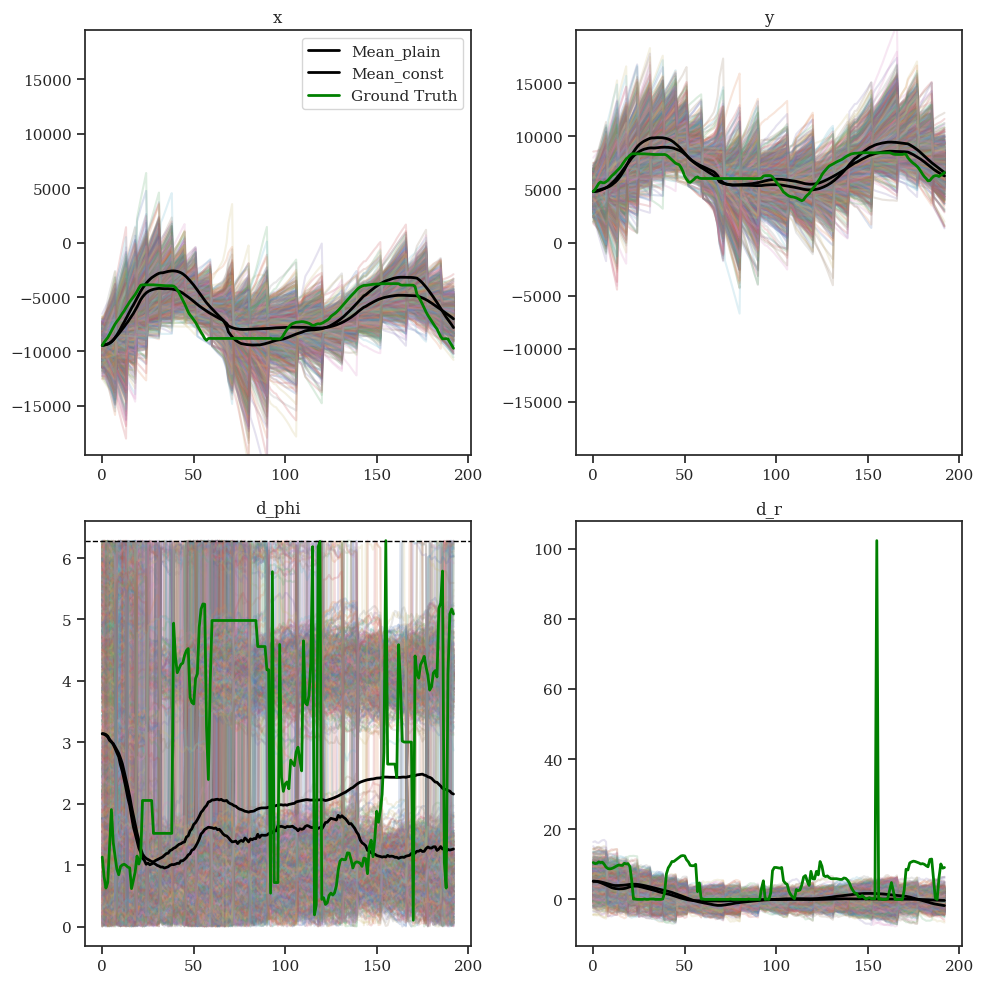

<Figure size 800x300 with 0 Axes>

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

columns = ["x", "y", "d_phi", "d_r"]

# time_start = 0
# time_end = 400

for i, ax in enumerate(axes.flatten()):
    if i >= result["particles"].shape[2]:
        break
    ax.plot(result["particles"][:, :, i], alpha=0.2)

    if i < result_pf["estimates"].shape[1]:
        ax.plot(result_pf["estimates"][:, i], c="black", lw=2, label="Mean_plain")
    if i < result_cofi["estimates"].shape[1]:
        ax.plot(result_cofi["estimates"][:, i], c="black", lw=2, label="Mean_const")

    if i < result["truth"].shape[1]:
        ax.plot(result["truth"][:, i], c="green", lw=2, label="Ground Truth")
    ax.set_title(columns[i])

    # ax.axvline(result["deviate_from"], c="black", ls="--", lw=1)

    if i == 0:
        ax.set_ylim(-width, width)
    if i == 1:
        ax.set_ylim(-height, height)

    if i == 0:
        ax.legend()

axes[1, 0].axhline(2 * pi, c="black", ls="--", lw=1)

plt.tight_layout()
plt.show()
plt.clf()

Lowered zoom level to keep map size reasonable. (z = 12)


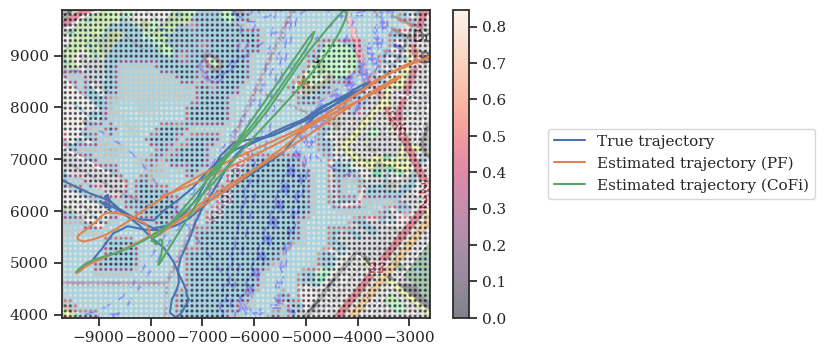

In [61]:
plt.figure(figsize=(6, 4))
bg = landscape.scatter(s=2, alpha=0.5)
plot_trajectories(result_pf["truth"][:, :2], label="True trajectory")
plot_trajectories(result_pf["estimates"][:, :2], label="Estimated trajectory (PF)")
plot_trajectories(result_cofi["estimates"][:, :2], label="Estimated trajectory (CoFi)")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
# plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
# plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

# plt.gca().set_xlim(-15_000, -2_000)
# plt.gca().set_ylim(8_000, 18_000)

all_coords = np.concatenate(
    [result_pf["truth"][:, :2], result_pf["estimates"][:, :2], result_cofi["estimates"][:, :2]]
)
plt.gca().set_xlim(all_coords[:, 0].min(), all_coords[:, 0].max())
plt.gca().set_ylim(all_coords[:, 1].min(), all_coords[:, 1].max())

# Move legend to the right of the plot
plt.legend()
move_legend(plt.gca(), loc="center left", bbox_to_anchor=(1.3, 0.5))

plt.colorbar(bg)
pass

### Visualize using Kepler.gl

In [62]:
def cartesian_to_polar(coords: ndarray) -> ndarray:
    collection = CartesianCollection(origin=origin, dimensions=1)
    collection.append_with_default(coords, np.nan)
    return collection.to_polar().coordinates()


def make_line_string(cartesian_coords: ndarray) -> str:
    return json.dumps(
        {
            "type": "LineString",
            "coordinates": cartesian_to_polar(cartesian_coords).tolist(),
        }
    )


start_date = "2023-08-01 0:0:00"
date_format = "%Y-%m-%d %X"


def make_route_points(cartesian_coords: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, 2)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                    },
                }
                for coord, time in zip(
                    cartesian_to_polar(cartesian_coords),
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
            ],
        }
    )


def make_particles(cartesian_coords: ndarray, weights: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, N, 2)
        weights: Shape (T, N)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                        "weight": weight,
                    },
                }
                for coords_t, weights_t, time in zip(
                    cartesian_coords,
                    weights,
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
                for coord, weight in zip(
                    cartesian_to_polar(coords_t),
                    weights_t.tolist(),
                )
            ],
        }
    )

In [63]:
subsample_particles = 4
map = KeplerGl(
    data={
        "True Trajectory Track": make_line_string(result_pf["truth"][:, :2]),
        "True Trajectory": make_route_points(result_pf["truth"][:, :2]),
        #
        "Estimated Trajectory (CoFi) Track": make_line_string(result_cofi["estimates"][:, :2]),
        "Estimated Trajectory (CoFi)": make_route_points(result_cofi["estimates"][:, :2]),
        #
        "Estimated Trajectory (PF) Track": make_line_string(result_pf["estimates"][:, :2]),
        "Estimated Trajectory (PF)": make_route_points(result_pf["estimates"][:, :2]),
        #
        "Particles (PF)": make_particles(
            result_pf["particles"][:, :subsample_particles, :2],
            weights=result_pf["weights"][:, :subsample_particles],
        ),
        "Particles (CoFi)": make_particles(
            result_cofi["particles"][:, :subsample_particles, :2],
            weights=result_cofi["weights"][:, :subsample_particles],
        ),
    },
    config={
        "version": "v1",
        "config": {
            "mapState": {
                "latitude": cartesian_to_polar(all_coords)[:, 1].mean(),
                "longitude": cartesian_to_polar(all_coords)[:, 0].mean(),
                "zoom": 11,
            },
            "visState": {
                "filters": [
                    {
                        "dataId": [data_field],
                        "id": f"94q7ipgwi-{data_field}",
                        "name": ["timestamp"],
                        "type": "DateTime",
                        "yAxis": None,
                        "speed": 0.2,
                    }
                    for data_field in [
                        "True Trajectory",
                        "Estimated Trajectory (CoFi)",
                        "Estimated Trajectory (PF)",
                        "Particles (PF)",
                        "Particles (CoFi)",
                    ]
                ]
            },
        },
    },
)
map.save_to_html(file_name="debug_keplergl.html")
map

TypeError: CartesianCollection.__init__() got an unexpected keyword argument 'dimensions'

You can now invoke `show-html.py` to serve the HTML file.

### Visualize the results with matplotlib

In [64]:
res_ = []
for vessel_type in interpolators:
    df_ = df[df["VesselTypeName"] == vessel_type]
    points = df_[["East", "North"]].values
    c = interpolators[vessel_type](points)
    for value in c:
        res_.append(
            {
                "Vessel Type": vessel_type,
                "Constitutional": value.item(),
            }
        )

res_df = pd.DataFrame(res_)
res_df

,Vessel Type,Constitutional
0,Cargo,0.84645
1,Cargo,0.84645
2,Cargo,0.84645
3,Cargo,0.84645
4,Cargo,0.84645
...,...,...
13613,Towing,0.00000
13614,Towing,0.00000
13615,Towing,0.00000
13616,Towing,0.00000


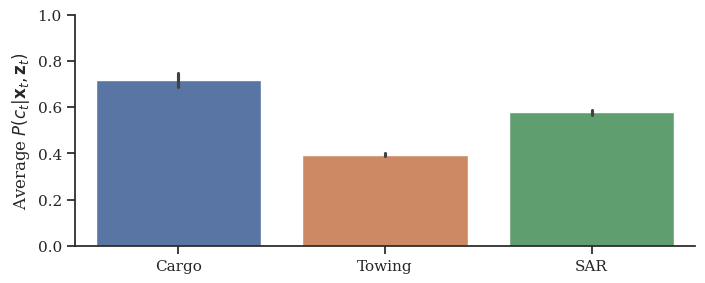

In [65]:
sns.barplot(
    data=res_df.replace({"Vessel Type": {"Search and rescue vessels": "SAR"}}),
    x="Vessel Type",
    y="Constitutional",
    hue="Vessel Type",
    order=["Cargo", "Towing", "SAR"],
    hue_order=["Cargo", "Towing", "SAR"],
)
sns.despine()
plt.ylabel(r"Average $P(c_t | \mathbf{x}_t, \mathbf{z}_t)$")
plt.xlabel("")
plt.ylim(0, 1)
plot_put = output_folder / "plots"
plot_put.mkdir(exist_ok=True)
plt.savefig(plot_put / "ais-constitution.pdf", bbox_inches="tight")
pass

In [66]:
# df_results.head()

,mmsi,type,tau,seed,particles,weights,estimates,pos_error,pos_error_mean,all_error,all_error_mean,truth
0,338533000,Towing,0.0,2024,"[[[-3615.226979284329, 7026.491069274527, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-4313.881695757326, 6133.951869498181, 3.141...","[25.873373359068513, 25.873373359068513, 25.30...",2890.424642,"[17.575854521776712, 18.079696742618065, 27.05...",289.437964,"[[-4309.139974887753, 6149.916229371825, 5.342..."
1,367078250,Towing,0.0,2024,"[[[-8967.026155500193, 5696.727483132134, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[-9665.680871973194, 4804.188283355786, 3.141...","[2351.8536140781353, 2066.6278431756236, 1789....",2829.252152,"[17.129295639788133, 272.7074535180284, 512.51...",385.949543,"[[-9660.939151103616, 4820.15264322943, 1.0681..."
2,367015880,Towing,0.0,2024,"[[[-8892.64213215062, 5664.427486925806, 1.383...","[[0.0005072512056533528, 0.0005026256090089099...","[[-9591.296848623602, 4771.888287149461, 3.141...","[1340.9615844951613, 1268.416609981096, 1219.6...",2306.062337,"[16.770506189741816, 151.4554889364029, 304.51...",637.387894,"[[-9586.555127754043, 4787.852647023104, 1.169..."
3,368111580,Search and rescue vessels,0.0,2024,"[[[3289.754472489906, -2315.548718873406, 1.38...","[[0.0005072512056533528, 0.0005026256090089099...","[[2591.099756016906, -3208.0879186497496, 3.14...","[1063.6923950227094, 1063.451107443954, 1064.0...",2486.440346,"[17.7182742986195, 16.75469932641871, 29.62579...",1556.687911,"[[2595.8414768864827, -3192.123558776109, 6.28..."
4,367078850,Towing,0.0,2024,"[[[-2169.1019173372424, 7445.553115740551, 1.3...","[[0.0005072512056533528, 0.0005026256090089099...","[[-2867.756633810242, 6553.013915964217, 3.141...","[398.09517447369103, 397.2388055662963, 396.39...",1698.274019,"[17.54317010195231, 34.9822393861334, 66.11801...",644.629640,"[[-2863.014912940666, 6568.978275837849, 1.218..."


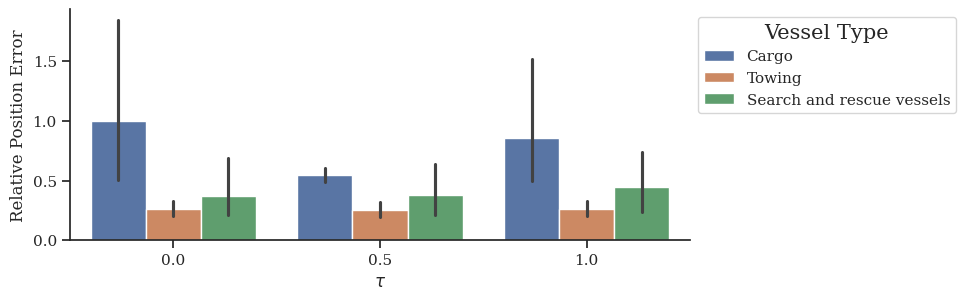

In [67]:
df_results_export = df_results.copy()[
    ["mmsi", "type", "tau", "seed", "pos_error_mean", "all_error_mean"]
]
df_results_export.to_csv(output_folder / "res-all-taus.csv", index=False)

df_ = df_results_export.rename(
    columns={
        "type": "Vessel Type",
        "tau": r"$\tau$",
        "pos_error_mean": "Relative Position Error",
    }
)
df_ = df_[df_["Relative Position Error"] < 100_000]
reference_error = df_[(df_["Vessel Type"] == "Cargo") & (df_[r"$\tau$"] == 0.0)][
    "Relative Position Error"
].mean()
df_["Relative Position Error"] /= reference_error
sns.barplot(
    x=r"$\tau$",
    y="Relative Position Error",
    hue="Vessel Type",
    data=df_[df_[r"$\tau$"].isin([0.0, 0.5, 1.0])],
    hue_order=["Cargo", "Towing", "Search and rescue vessels"],
)

# move the legend outside
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

sns.despine()

plt.savefig(plot_put / "relative_position_error.pdf", bbox_inches="tight")
pass

In [ ]:
type_wise_data = []

for type in df_["Vessel Type"].unique():
    type_data = df_[df_["Vessel Type"] == type].copy()
    type_data["Relative Position Error"] /= type_data["Relative Position Error"][
        type_data[r"$\tau$"] == 0
    ].mean()
    type_wise_data.append(type_data)

normalized_data = pd.concat(type_wise_data)

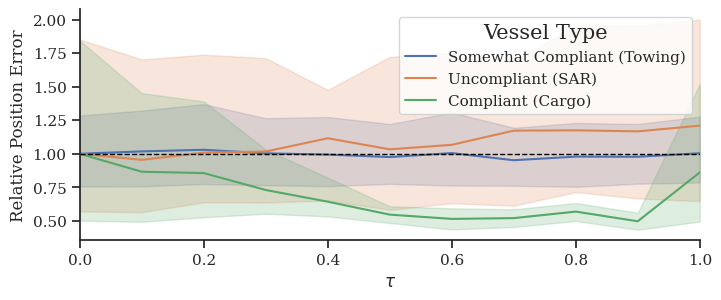

In [77]:
sns.lineplot(
    x=r"$\tau$",
    y="Relative Position Error",
    hue="Vessel Type",
    data=normalized_data.replace(
        {
            "Vessel Type": {
                "Search and rescue vessels": "Uncompliant (SAR)",
                "Cargo": "Compliant (Cargo)",
                "Towing": "Somewhat Compliant (Towing)",
            }
        }
    ),
)
plt.axhline(1, c="black", ls="--", lw=1)
plt.xlim(0, 1)
sns.despine()
pass

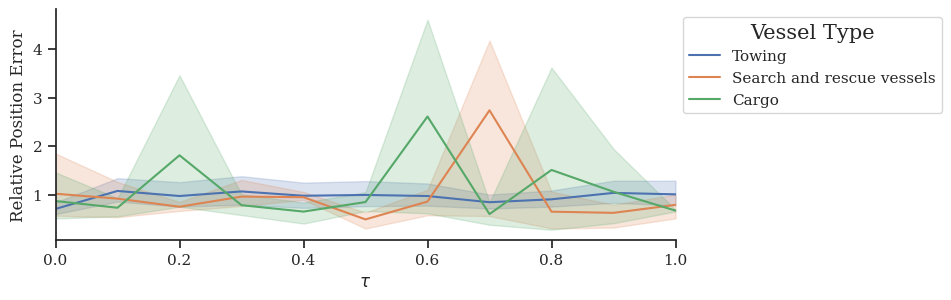

In [ ]:
# # sns.barplot(x="tau", y="all_error_mean", hue="type", data=df_results)
# df_rel = df_.copy()
# # Divide the error by the reference error for each Vessel Type @ tau = 0
# df_rel["Relative Position Error"] = (
#     # TODO why is this odd?
#     df_rel.groupby("Vessel Type")
#     .apply(
#         lambda x: x["Relative Position Error"]
#         / x[x[r"$\tau$"] == 0]["Relative Position Error"].mean(),
#         include_groups=False,
#     )
#     .reset_index()["Relative Position Error"]
# )
# sns.lineplot(
#     x=r"$\tau$",
#     y="Relative Position Error",
#     hue="Vessel Type",
#     data=df_rel,
# )
# sns.despine()
# plt.xlim(0, 1)
# sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
# pass

In [ ]:
sns.barplot(x="tau", y="pos_error_mean", hue="type", data=df_results)
plt.ylim(None, 30_000)

In [ ]:
# Groub by MMSI and trhen take the tau with the lowest error each
# df_results[["mmsi", "pos_error_mean"]].groupby("mmsi").apply(
#     lambda x: x.sort_values("tau").loc[x["pos_error_mean"].idxmin()]
# )
res = []
for mmis in df_results["mmsi"].unique():
    df_ = df_results[df_results["mmsi"] == mmis]
    # sort by tau
    df_ = df_.sort_values("pos_error_mean")
    res.append((df_["type"].iloc[0], df_["tau"].iloc[0]))

res = pd.DataFrame(res, columns=["Vessel Type", r"$\tau$"])
# Rname Search and rescue vessels to SAR
res["Vessel Type"] = res["Vessel Type"].replace("Search and rescue vessels", "SAR")
res

In [ ]:
r_ = res.copy()

# r_["Vessel Type"] = "All"
# res_ = pd.concat([res, r_], axis=0)
# res_.sort_values("Vessel Type", inplace=True)

sns.histplot(
    r_,
    x=r"$\tau$",
    hue="Vessel Type",
    multiple="stack",
    bins=10,
    stat="percent",
    shrink=0.75,
    # palette="colorblind",
)

plt.ylabel("")
plt.yticks(plt.yticks()[0], [f"{i.get_text()}%" for i in plt.yticks()[1]])
sns.despine()

# Fix the placmenet of the x-axis
plt.xticks(np.arange(0, 1.1, 0.1) + 0.05, [f"{i:.1f}" for i in np.arange(0, 1.1, 0.1)])

plt.savefig(Path(".") / "plots" / "tau-distribution.pdf", bbox_inches="tight")

pass

In [ ]:
sns.displot(
    df_results,
    x="pos_error_mean",  # or "all_error"
    col="tau",
    col_wrap=3,
    facet_kws=dict(margin_titles=True),
)

## Older stuff

In [ ]:
results = []

df_for_type = df[df["VesselTypeName"].isin(["Cargo", "Cargo hazardous"])]

for tau in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    for mmsi in relevant_MMSIs:
        for seed_value in [2024]:
            data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
            if data.empty:
                continue
            vessel_type = data["VesselTypeName"].iloc[0]
            experiment_result = run_experiment(
                data, constitutional_trust=tau, seed_value=seed_value, verbose=False
            )
            results.append(
                dict(
                    mmsi=mmsi,
                    type=vessel_type,
                    tau=tau,
                    seed=seed_value,
                    mean_mean=np.mean(experiment_result["position_accuracy_mean"]),
                    mean_std=np.std(experiment_result["position_accuracy_mean"]),
                    map_mean=np.mean(experiment_result["position_accuracy_map"]),
                    map_std=np.std(experiment_result["position_accuracy_map"]),
                    **experiment_result,
                )
            )
            print(f"Finished {mmsi} (progress: {len(results)}/{len(df_for_type['MMSI'].unique())})")

df_results = pd.DataFrame(results)
df_results

In [ ]:
sns.displot(
    df_results,
    x="mean_mean",
    col="tau",
    col_wrap=3,
    facet_kws=dict(margin_titles=True),
)

In [ ]:
g = sns.catplot(
    data=df_results,
    kind="bar",
    x="tau",
    y="mean_mean",
    errorbar="sd",
    alpha=0.6,
    height=6,
)

In [ ]:
# Visualize the weights of the particles
plt.plot(result["trace_weights_unnormalized"])
pass

In [ ]:
plt.plot(np.diff(result["trace_time"]) / 60)
pass

In [ ]:
# plt.hist(trace_all_particles[20, :, 2].ravel(), bins=100)
# pass

In [ ]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.1, alpha=0.5)
plot_trajectories(result["ground_truth"], label="True trajectory")
plot_trajectories(result["trace_state"][:, :2], label="Estimated trajectory")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

plt.colorbar()
plt.legend()
pass

In [ ]:
plt.figure(figsize=(6, 4))
plt.gca().set_aspect("equal")
landscape.scatter(s=0.1, alpha=0.2)
# plt.scatter(*result["trace_all_particles"][:, :, :2][50, ...].T, c="r", s=1)
plt.scatter(*debug_df[["East", "North"]].values.T, c="r", s=1)
plt.xlim(-width / 2 * scale, width / 2 * scale)
plt.ylim(-height / 2 * scale, height / 2 * scale)

pass

In [ ]:
index = 30

plt.gca().set_aspect("equal")

# draw a box around the observed frame
plt.plot(
    [-width / 2, width / 2, width / 2, -width / 2, -width / 2],
    [-height / 2, -height / 2, height / 2, height / 2, -height / 2],
    "k-",
    alpha=0.3,
    label="Frame",
)

plot_trajectories(result["ground_truth"], label="True trajectory", color="k", alpha=0.3)

plt.hist2d(
    *result["trace_all_particles"][index, :, :2].T,
    bins=50,
    range=[[-width / 2 * scale, width / 2 * scale], [-height / 2 * scale, height / 2 * scale]],
    cmap="Oranges",
)

if index > 0:
    # Plot the ship position and position estimate at that time point
    plt.gca().plot(
        *result["ground_truth"][index - 1],
        marker=ship_marker,
        markersize=14,
        label="True position",
        c="k",
        alpha=0.5,
    )
    plt.gca().plot(
        *result["trace_state"][index - 1, :2],
        marker=ship_marker,
        markersize=14,
        label="Estimated position",
        c="b",
    )


plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
pass

In [ ]:
res_starmap = pd.DataFrame(
    [
        dict(name=r"StarMap ($100 \times x 100$)", time=640.4149391481187),
        dict(name=r"StarMap ($100 \times x 100$)", time=627.0258562378585),
        dict(name=r"StarMap ($100 \times x 100$)", time=624.6253640819341),
        #
        dict(name=r"StarMap ($50 \times 50$)", time=495.63382973195985),
        dict(name=r"StarMap ($50 \times 50$)", time=487.28305474994704),
        dict(name=r"StarMap ($50 \times 50$)", time=487.8447328049224),
    ]
)
res_perf = pd.DataFrame(
    [
        dict(name="Particle Filter", time=0.03765651909634471 / 20),
        dict(name="Particle Filter", time=0.0383494570851326 / 20),
        dict(name="Particle Filter", time=0.03719700896181166 / 20),
        #
        dict(name="CoFi", time=113.63170561008155 / 20),
        dict(name="CoFi", time=113.54428059794009 / 20),
        dict(name="CoFi", time=113.22225885814987 / 20),
        #
        dict(name="CoFi Precomputed", time=0.051308222813531756 / 20),
        dict(name="CoFi Precomputed", time=0.04675357579253614 / 20),
        dict(name="CoFi Precomputed", time=0.05256968503817916 / 20),
    ]
)
cocktail = pd.DataFrame(
    [
        dict(name=r"StarMap ($100 \times 100$)", time=640.4149391481187),
        dict(name=r"StarMap ($100 \times 100$)", time=627.0258562378585),
        dict(name=r"StarMap ($100 \times 100$)", time=624.6253640819341),
        #
        dict(name=r"StarMap ($50 \times 50$)", time=495.63382973195985),
        dict(name=r"StarMap ($50 \times 50$)", time=487.28305474994704),
        dict(name=r"StarMap ($50 \times 50$)", time=487.8447328049224),
        #
        dict(name="CoFi\n10 iterations", time=113.63170561008155 / 20 * 10),
        dict(name="CoFi\n10 iterations", time=113.54428059794009 / 20 * 10),
        dict(name="CoFi\n10 iterations", time=113.22225885814987 / 20 * 10),
    ]
)
cocktail

In [ ]:
sns.barplot(data=cocktail, x="name", y="time", hue="name", palette="colorblind")
plt.xlabel("")
sns.despine()